In [1]:
import MGTomo.model as mgmodel
import time
import numpy as np
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import myexp, mylog, mydiv
import MGTomo.functions as fcts
from skimage import data
from skimage.transform import resize
from MGTomo.optimize import armijo_linesearch_box

from MGTomo.gridop import P,R, RBox, PBox

import torch
from torch.func import grad

from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 

In [2]:
max_levels = 1
maxIter = [1,1,5,5,5]

In [3]:
N = 255
# load image
x_orig = data.shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [4]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 50, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}

for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
    b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [46]:
#c0 = A[0].sumnorm()
#tau0 = 0.5 * 1/c0

In [5]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])

In [6]:
#c0 = 56.0952
#tau0 = 0.5 * 1/c0

c0 = 100
tau0 = 0.5 * 1/c0

In [8]:
tau = [tau0]*(max_levels+1)

In [7]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
    gcond = (matrix_norm(R(grad_y), ord = 1) >= kappa * matrix_norm(grad_y, ord = 1))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y, ord = 1)
        y_norm = matrix_norm(y, ord = 1)
        return gcond and (y_diff_norm >= eta * y_norm)
    else:
        #print('y_last was none')
        return gcond

In [9]:
def coarse_condition_v3(grad_y, kappa, eps):
    Rgrady = matrix_norm( 0.25 * R(grad_y), ord = 1)
    gcond_rel = (Rgrady >= kappa * matrix_norm(grad_y, ord = 1))
    gcond = (Rgrady >= eps)
    
    return gcond_rel and gcond

In [10]:
def coarse_condition(y, grad_y, kappa, y_last = None):
    gcond = (matrix_norm(0.25 * R(grad_y), ord = 1) >= kappa * matrix_norm(grad_y, ord = 1))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y, ord = 1)
        return gcond and (y_diff_norm >= kappa)
    else:
        return gcond
    
def MLO_box(fh, y, last_pts: list, l=0, kappa = 0.49, eps = 1e-3, verbose = True):
    x = 1/16 * R(y).detach().requires_grad_(True)
    y0, x0 = y, x.clone().detach().requires_grad_(True)
    
    fhy0 = fh(y0)
    fhy0.backward(retain_graph = True)
    grad_fhy0 = y0.grad.clone()
    y0.grad.zero_()
    
    #print('coarse correction at l = ', l)
    #if coarse_condition(y, grad_fhy0, kappa, last_pts[l]):
    if coarse_condition_v3(grad_fhy0, kappa, eps):
        print(l, ' : coarse correction activated')
        #print('kl(y^*, y^k): ', fcts.kl_distance_no_matrix(x_torch, y0))

        last_pts[l] = y0.clone().detach()
    
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = 0.25 * R(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * x)
        
        for i in range(maxIter[l]):
            x.retain_grad()
            val = fcts.BSMART(psi, x, tau[l+1])
            x = val.clone().detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts, _ = MLO_box(psi, x, last_pts, l+1, verbose=verbose)

        assert psi(x) <= fH(x0) + torch.sum(kappa * x0), 'psi(x) < psi(x0) = fH(x0) does not hold'
    else: 
        print(l, ' : coarse correction not activated')
    
    d = 0.25 * P(x-x0)
    z, a = armijo_linesearch_box(fh, y0, d, verbose = verbose)
    #print('kl(y^*, z): ', fcts.kl_distance_no_matrix(x_torch, z))
    
    assert z.min() >= 0
    
    for i in range(maxIter[l]):
        z.retain_grad()
        zval = fcts.BSMART(fh, z, tau[l])
        y0.grad.zero_()
        z = zval.clone().detach().requires_grad_(True)
    #print('kl(y^*, y^k+1): ', fcts.kl_distance_no_matrix(x_torch, z))
    return z, last_pts, a


In [11]:
a = []
z0 = torch.rand(N, N, requires_grad = True)
w0 = z0.clone().detach().requires_grad_(True)
fhz0 = fh(z0).item()
last_pts = [None]*(max_levels+1)


iteration_times_ML = []
overall_start_time_ML = time.process_time()  # Start overall timing

fval_ML = []

for i in range(100):
    iteration_start_time_ML = time.process_time()  # Start timing for this iteration
    
    val, ylast, alpha = MLO_box(fh, z0, last_pts, verbose=False)
    z0 = val.clone().detach().requires_grad_(True)
    a.append(alpha)
    
    iteration_end_time_ML = time.process_time()  # End timing for this iteration
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML  # Calculate elapsed time for this iteration
    iteration_times_ML.append(iteration_time_ML)

    fval_ML.append(fh(z0).detach().numpy()/fhz0)
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

overall_end_time_ML = time.process_time()  # End overall timing
overall_time_ML = overall_end_time_ML - overall_start_time_ML  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated
Iteration 0: 192610.5724818722 - Time: 9.057086 seconds
0  : coarse correction activated
Iteration 1: 147551.73954989924 - Time: 7.849424 seconds
0  : coarse correction activated
Iteration 2: 114377.06853912104 - Time: 7.832225 seconds
0  : coarse correction activated
Iteration 3: 89444.7605017115 - Time: 7.862697 seconds
0  : coarse correction activated
Iteration 4: 70553.9197062294 - Time: 7.841016 seconds
0  : coarse correction activated
Iteration 5: 56193.260535451 - Time: 8.756248 seconds
0  : coarse correction activated
Iteration 6: 45257.92376451268 - Time: 8.624714 seconds
0  : coarse correction activated
Iteration 7: 36917.95067444534 - Time: 7.791953 seconds
0  : coarse correction activated
Iteration 8: 30543.796984419234 - Time: 7.832747 seconds
0  : coarse correction activated
Iteration 9: 25657.010382111297 - Time: 7.841888 seconds
0  : coarse correction activated
Iteration 10: 21894.50113769763 - Time: 7.831597 seconds
0  : coarse correcti

In [12]:
iteration_times_SL = []
overall_start_time_SL = time.process_time()  # Start overall timing

fval_SL = []

for i in range(100):
    iteration_start_time_SL = time.process_time()  # Start timing for this iteration
    
    val = fcts.BSMART(fh, w0, tau0)
    w0 = val.clone().detach().requires_grad_(True)
    
    iteration_end_time_SL = time.process_time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    iteration_times_SL.append(iteration_time_SL)

    fval_SL.append(fh(w0).item()/fhz0)
    
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

overall_end_time_SL = time.process_time()  # End overall timing
overall_time_SL = overall_end_time_SL - overall_start_time_SL  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]


Iteration 0: 192649.8550349757 - Time: 1.224920 seconds
Iteration 1: 147598.54790689546 - Time: 1.506125 seconds
Iteration 2: 114426.35416057611 - Time: 1.505420 seconds
Iteration 3: 89493.0683267399 - Time: 1.507865 seconds
Iteration 4: 70599.13379748809 - Time: 1.498367 seconds
Iteration 5: 56234.288096990655 - Time: 1.506520 seconds
Iteration 6: 45294.36886616144 - Time: 1.504989 seconds
Iteration 7: 36949.87454676206 - Time: 1.507160 seconds
Iteration 8: 30571.507276188262 - Time: 1.501263 seconds
Iteration 9: 25680.956209626733 - Time: 1.507058 seconds
Iteration 10: 21915.171318248595 - Time: 1.501813 seconds
Iteration 11: 18999.260858559446 - Time: 1.506393 seconds
Iteration 12: 16725.603835546608 - Time: 1.488592 seconds
Iteration 13: 14937.713413759431 - Time: 2.014723 seconds
Iteration 14: 13517.834349410194 - Time: 2.099422 seconds
Iteration 15: 12377.44627490877 - Time: 2.102235 seconds
Iteration 16: 11450.03228964672 - Time: 2.100970 seconds
Iteration 17: 10685.605107262261

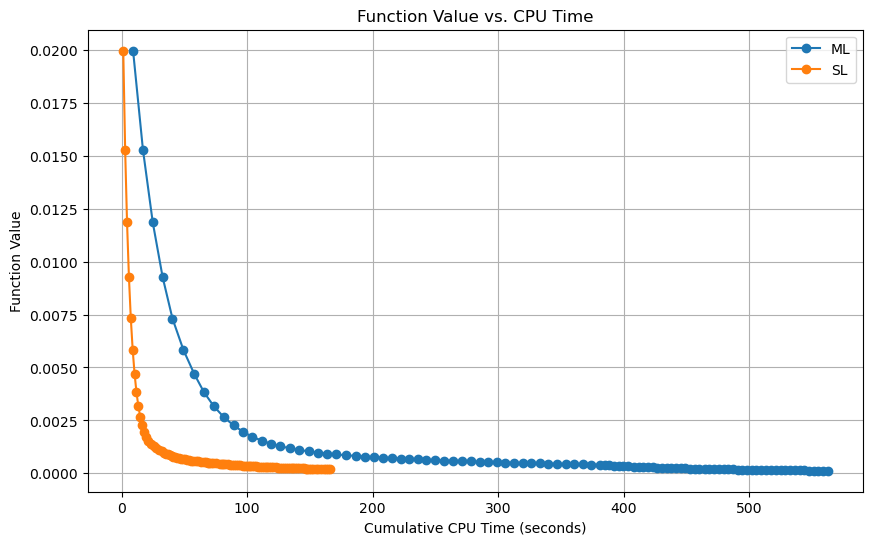

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(cumaltive_times_ML, fval_ML, marker='o', linestyle='-', label = 'ML')
plt.plot(cumaltive_times_SL, fval_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('Function Value')
plt.title('Function Value vs. CPU Time')
plt.grid(True)
plt.legend()
plt.show()

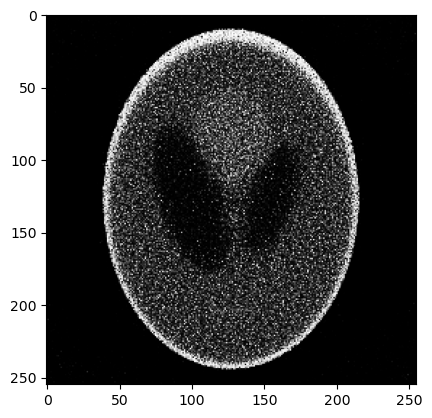

In [56]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')